🔥 开始神经架构搜索...
100%|██████████| 600/600 [00:14<00:00, 40.54trial/s, best loss: 1.2617233294260244] 


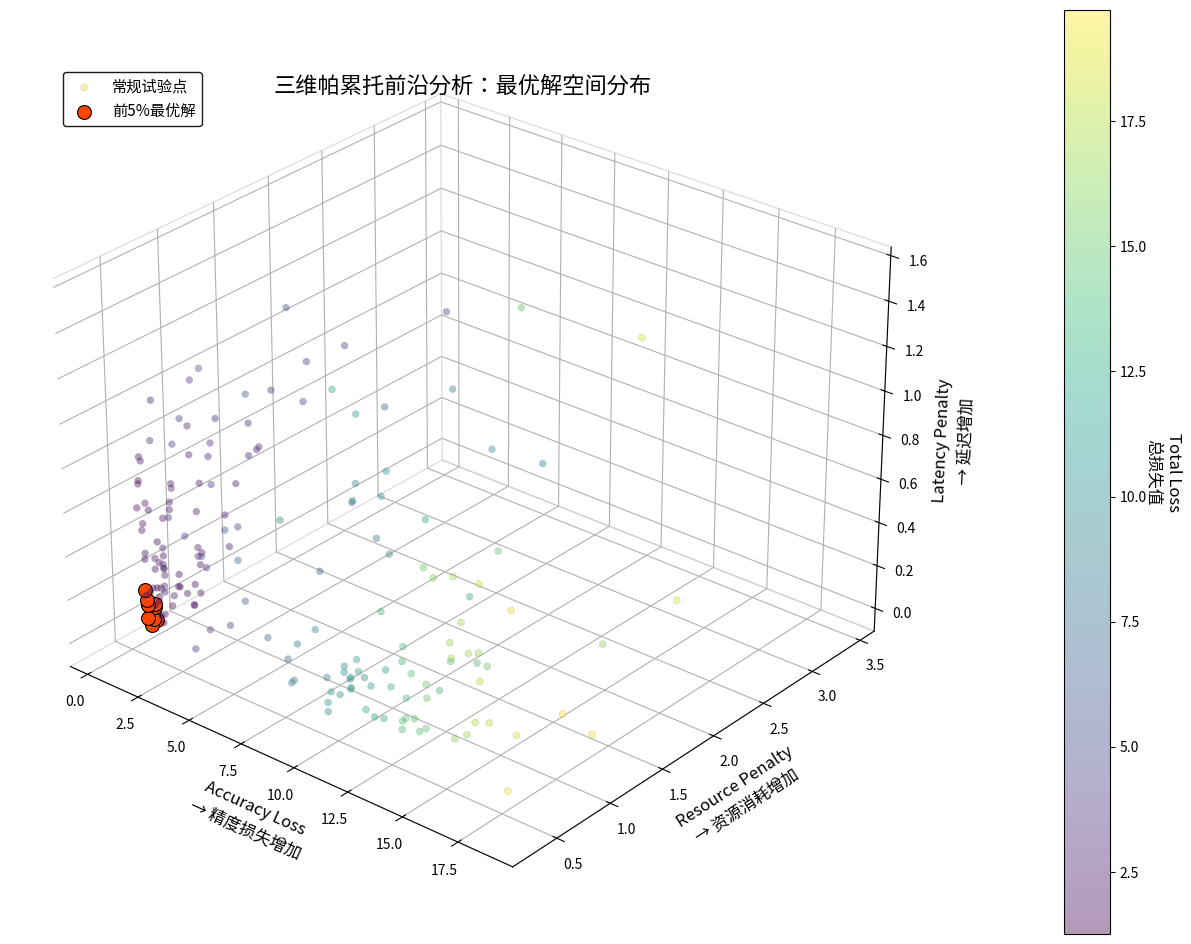


🏆 前五个最优结果:

🔧 参数配置:
  量化总位宽: 4
  量化整数位宽: 1
  HLS总位宽: 16
  HLS整数位宽: 8
  重用因子: 1
  剪枝初始: 0.1617
  剪枝最终: 0.3808
🔹 总损失: 1.2617
- Python准确率: 79.22%
- HLS准确率: 81.99%
- 资源占用 [BRAM/DSP/FF/LUT]: 48.9%/61.2%/50.5%/104.4%
- 延迟: 282.91μs

🔧 参数配置:
  量化总位宽: 4
  量化整数位宽: 1
  HLS总位宽: 14
  HLS整数位宽: 8
  重用因子: 1
  剪枝初始: 0.2135
  剪枝最终: 0.3744
🔹 总损失: 1.2731
- Python准确率: 78.93%
- HLS准确率: 83.79%
- 资源占用 [BRAM/DSP/FF/LUT]: 44.0%/84.0%/43.5%/96.0%
- 延迟: 342.03μs

🔧 参数配置:
  量化总位宽: 4
  量化整数位宽: 1
  HLS总位宽: 15
  HLS整数位宽: 9
  重用因子: 1
  剪枝初始: 0.2299
  剪枝最终: 0.3460
🔹 总损失: 1.2846
- Python准确率: 78.69%
- HLS准确率: 85.10%
- 资源占用 [BRAM/DSP/FF/LUT]: 46.3%/88.1%/47.9%/104.7%
- 延迟: 181.40μs

🔧 参数配置:
  量化总位宽: 4
  量化整数位宽: 1
  HLS总位宽: 13
  HLS整数位宽: 8
  重用因子: 1
  剪枝初始: 0.2416
  剪枝最终: 0.3066
🔹 总损失: 1.3015
- Python准确率: 78.59%
- HLS准确率: 82.46%
- 资源占用 [BRAM/DSP/FF/LUT]: 41.4%/98.6%/43.5%/94.3%
- 延迟: 54.11μs

🔧 参数配置:
  量化总位宽: 4
  量化整数位宽: 1
  HLS总位宽: 14
  HLS整数位宽: 7
  重用因子: 1
  剪枝初始: 0.1683
  剪枝最终: 0.3653
🔹 总损失: 1.3019
- Python准确率: 79.25%

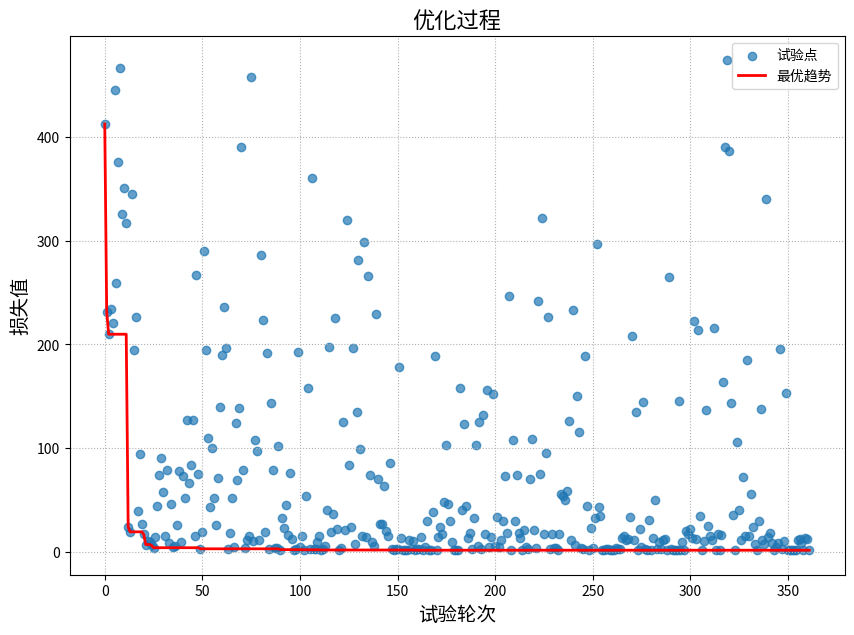

In [21]:
import torch
import numpy as np
import torch.nn as nn
from joblib import load
import matplotlib.pyplot as plt
import torch.nn.functional as F
from hyperopt.pyll import scope
from hyperopt import fmin, tpe, hp, STATUS_OK

# 初始化全局变量
best_loss = float('inf')
trials = []  # 记录每次试验的详细信息
history = []   # 记录每次迭代的损失值
best_history = []  # 记录历史最优值
plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']  # 解决中文显示问题

#=============================================================================
# 模型及数据标准化部分
#=============================================================================
# 标准化
scaler_X = load("scaler_X.pkl")
scaler_y = load("scaler_y.pkl")

# 硬件指标预测模型
class FCnet(nn.Module):
    def __init__(self, hidden_dim=1536):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(7, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),
            nn.Linear(hidden_dim//2, 7)
        )
    
    def forward(self, x):
        return self.net(x)

class ImprovedFCnet(nn.Module):
    def __init__(self, hidden_dim=640, dropout_rate=0.2):
        super(ImprovedFCnet, self).__init__()

        # 第一层：输入7维到hidden_dim，高维特征提取
        self.fc1 = nn.Linear(7, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        # 第二层：降维到hidden_dim//2
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.bn2 = nn.BatchNorm1d(hidden_dim // 2)
        # 第三层：降回7维
        self.fc3 = nn.Linear(hidden_dim // 2, 7)
        # Dropout层，防止过拟合
        self.dropout = nn.Dropout(dropout_rate)
        
    def forward(self, x):
        # 保存输入，用于后续残差连接（当输入输出维度一致时）
        residual = x
        
        # 第一层：线性 -> BN -> ReLU -> Dropout
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        # 第二层：线性 -> BN -> ReLU -> Dropout
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        # 第三层：线性
        x = self.fc3(x)
        
        # 如果输入维度与输出维度相同，则加上残差连接
        if residual.shape[-1] == x.shape[-1]:
            x = x + residual
        return x

# 加载预训练模型
model = ImprovedFCnet()
model.load_state_dict(torch.load("resnet_hls4ml.pth"))
model.eval()

# 全局参数约束
QUANT_INT_MAX = 10
HLS_INT_MAX = 15

#=============================================================================
# 参数转换函数（保持不变）
#=============================================================================
def adjust_parameters(params):
    """参数调整逻辑保持不变"""
    (quant_total_bit_width, quant_int_param,
     hls_total_bit_width, hls_int_param,
     reuse_factor, pruning_initial, pruning_final) = params

    # 映射量化整数位宽
    quant_target_min = 0
    quant_target_max = quant_total_bit_width - 1
    quant_integer_bit_width = quant_target_min + int(round(
        (quant_int_param / QUANT_INT_MAX) * (quant_target_max - quant_target_min)
    ))

    # 映射 hls4ml 整数位宽
    hls_target_min = 1
    hls_target_max = hls_total_bit_width - 1
    hls_integer_bit_width = hls_target_min + int(round(
        (hls_int_param / HLS_INT_MAX) * (hls_target_max - hls_target_min)
    ))

    return [
        quant_total_bit_width,
        quant_integer_bit_width,
        hls_total_bit_width,
        hls_integer_bit_width,
        reuse_factor,
        pruning_initial,
        pruning_final
    ]

#=============================================================================
# 定义超参数空间
#=============================================================================
space = {
    'quant_total_bit_width': scope.int(hp.quniform('q_total', 3, 12, 1)),
    'quant_int_param':       scope.int(hp.quniform('q_int',   0, QUANT_INT_MAX, 1)),
    'hls_total_bit_width':   scope.int(hp.quniform('h_total', 3, 18, 1)),
    'hls_int_param':         scope.int(hp.quniform('h_int',   0, HLS_INT_MAX, 1)),
    'reuse_factor':          hp.choice('reuse', [1, 1000]),   # 仅取值 1 或 1000
    'pruning_initial':       hp.uniform('p_init',  0.0, 0.5),
    'pruning_final':         hp.uniform('p_final', 0.0, 1.0)
}

#=============================================================================
# 定义损失函数，各项权重均取自上面定义的常量
#=============================================================================
def compute_loss(python_acc, hls_acc, bram, dsp, ff, lut, latency):
    # 准确率硬约束：
    if hls_acc < 80:
        # 低于 70 时惩罚大幅增加：(75-hls_acc)^2 × 高系数
        hls_penalty = (80 - hls_acc)**2 * 0.1  # 系数调至平衡其他项
    else:
        hls_penalty = 0
    
    if python_acc < 80:
        # 低于 75 时惩罚大幅增加：(75-hls_acc)^2 × 高系数
        python_penalty = (80 - python_acc)**2 * 0.1 # 系数调至平衡其他项
    else:
        python_penalty = 0
    
    # 准确率损失项（HLS 权重更高）
    accuracy_loss = (1 - hls_acc/100) * 3  # 原 HLS 损失
    accuracy_loss += hls_penalty + python_penalty  # 低于 75 时的额外惩罚
    
    # 资源惩罚（超限后线性增长，系数较低）
    resources = [bram, dsp, ff, lut]
    resource_penalty = 0
    for r in resources:
        if r <= 100:
            resource_penalty += r / 500    # 未超限：缓增分母
        else:
            over = r - 100
            resource_penalty += (100 + 3 * over) / 500  # 超限后每单位×3
    
    # 延迟惩罚（超 10ms 直接失效）
    if latency > 10000:
        latency_penalty = 100.0
    else:
        latency_penalty = latency / 2500
    
    # 总损失（确保 HLS 核心地位）
    total_loss = accuracy_loss + resource_penalty + latency_penalty
    return total_loss, accuracy_loss, resource_penalty, latency_penalty

#=============================================================================
# 目标函数
#=============================================================================
def objective(params):
    global best_loss, history, best_history, trials
    try:
        # 将参数字典转换为原始参数列表
        raw_params = [
            params['quant_total_bit_width'],
            params['quant_int_param'],
            params['hls_total_bit_width'],
            params['hls_int_param'],
            params['reuse_factor'],
            params['pruning_initial'],
            params['pruning_final']
        ]
        
        # 参数调整和验证
        adjusted_params = adjust_parameters(raw_params)
        qtb, qib, htb, hib, rf, pi, pf = adjusted_params
        
        # 有效性检查
        if not (0 <= qib < qtb):
            return {'loss': 1e6, 'status': STATUS_OK}
        if not (1 <= hib < htb):
            return {'loss': 1e6, 'status': STATUS_OK}
        if pf <= pi:
            return {'loss': 1e6, 'status': STATUS_OK}

        # 模型预测
        norm_input = scaler_X.transform(np.array(adjusted_params).reshape(1, -1))
        input_tensor = torch.tensor(norm_input, dtype=torch.float32)
        with torch.no_grad():
            outputs = model(input_tensor).numpy().flatten()
        
        # 结果解析
        outputs_inv = scaler_y.inverse_transform(outputs.reshape(1, -1))[0]
        python_acc = outputs_inv[0] * 100
        hls_acc = outputs_inv[1] * 100
        bram, dsp, ff, lut, latency = outputs_inv[2:7]

        # 检查硬件指标是否为负
        if any(x < 0 for x in [bram, dsp, ff, lut, latency]):
            return {'loss': 1e6, 'status': STATUS_OK}
        
        # 损失计算
        total_loss, accuracy_loss, resource_penalty, latency_penalty = compute_loss(
            python_acc, hls_acc, bram, dsp, ff, lut, latency
        )
        
        # 记录试验详情
        current_trial = {
            'params': params.copy(),
            'adjusted_params': adjusted_params.copy(),
            'python_acc': python_acc,
            'hls_acc': hls_acc,
            'bram': bram,
            'dsp': dsp,
            'ff': ff,
            'lut': lut,
            'latency': latency,
            'total_loss': total_loss,
            'accuracy_loss': accuracy_loss,
            'resource_penalty': resource_penalty,
            'latency_penalty': latency_penalty,
            'status': 'ok'
        }
        trials.append(current_trial)

        # 更新历史记录
        history.append(total_loss)
        if total_loss < best_loss:
            best_loss = total_loss
        best_history.append(best_loss)

        return {'loss': total_loss, 'status': STATUS_OK}
    
    except Exception as e:
        print(f"参数错误: {str(e)}")
        return {'loss': 1e6, 'status': STATUS_OK}

#=============================================================================
# 可视化函数
#=============================================================================
def plot_optimization_process(history, best_history):
    plt.figure(figsize=(10, 7))
    plt.scatter(range(len(history)), history, c='#1f77b4', alpha=0.7, label='试验点')
    plt.plot(best_history, 'r-', lw=2, label='最优趋势')
    plt.xlabel('试验轮次', fontsize=14)
    plt.ylabel('损失值', fontsize=14)
    plt.title('优化过程', fontsize=16)
    plt.grid(True, linestyle=':')
    plt.legend()
    plt.savefig('visualization/nas_optimization.png', dpi=350, bbox_inches='tight')
    plt.show()
    plt.close()

# 帕累托前沿分析函数
def find_pareto_front(trials_data):
    pareto_indices = []
    for i, point in enumerate(trials_data):
        dominated = False
        for j, other in enumerate(trials_data):
            if i == j:
                continue
            if (other['accuracy_loss'] <= point['accuracy_loss'] and
                other['resource_penalty'] <= point['resource_penalty'] and
                other['latency_penalty'] <= point['latency_penalty']):
                if (other['accuracy_loss'] < point['accuracy_loss'] or
                    other['resource_penalty'] < point['resource_penalty'] or
                    other['latency_penalty'] < point['latency_penalty']):
                    dominated = True
                    break
        if not dominated:
            pareto_indices.append(i)
    return pareto_indices

# 帕累托前沿可视化函数
def plot_pareto_front(valid_trials, pareto_indices, top5_indices):
    plt.figure(figsize=(15, 5))
    
    # 子图1：Accuracy Loss vs Resource Penalty
    plt.subplot(131)
    x = [t['accuracy_loss'] for t in valid_trials]
    y = [t['resource_penalty'] for t in valid_trials]
    c = [t['latency_penalty'] for t in valid_trials]
    plt.scatter(x, y, c=c, cmap='viridis', alpha=0.6)
    plt.scatter(
        [valid_trials[i]['accuracy_loss'] for i in pareto_indices],
        [valid_trials[i]['resource_penalty'] for i in pareto_indices],
        edgecolor='red', facecolor='none', s=80, label='帕累托前沿'
    )
    plt.scatter(
        [valid_trials[i]['accuracy_loss'] for i in top5_indices],
        [valid_trials[i]['resource_penalty'] for i in top5_indices],
        marker='*', s=150, c='gold', edgecolor='black', label='前五最优'
    )
    plt.xlabel('Accuracy Loss')
    plt.ylabel('Resource Penalty')
    plt.colorbar(label='Latency Penalty')

    # 子图2：Resource Penalty vs Latency Penalty
    plt.subplot(132)
    x = [t['resource_penalty'] for t in valid_trials]
    y = [t['latency_penalty'] for t in valid_trials]
    c = [t['accuracy_loss'] for t in valid_trials]
    plt.scatter(x, y, c=c, cmap='viridis', alpha=0.6)
    plt.scatter(
        [valid_trials[i]['resource_penalty'] for i in pareto_indices],
        [valid_trials[i]['latency_penalty'] for i in pareto_indices],
        edgecolor='red', facecolor='none', s=80
    )
    plt.scatter(
        [valid_trials[i]['resource_penalty'] for i in top5_indices],
        [valid_trials[i]['latency_penalty'] for i in top5_indices],
        marker='*', s=150, c='gold', edgecolor='black'
    )
    plt.xlabel('Resource Penalty')
    plt.ylabel('Latency Penalty')
    plt.colorbar(label='Accuracy Loss')

    # 子图3：Accuracy Loss vs Latency Penalty
    plt.subplot(133)
    x = [t['accuracy_loss'] for t in valid_trials]
    y = [t['latency_penalty'] for t in valid_trials]
    c = [t['resource_penalty'] for t in valid_trials]
    plt.scatter(x, y, c=c, cmap='viridis', alpha=0.6)
    plt.scatter(
        [valid_trials[i]['accuracy_loss'] for i in pareto_indices],
        [valid_trials[i]['latency_penalty'] for i in pareto_indices],
        edgecolor='red', facecolor='none', s=80
    )
    plt.scatter(
        [valid_trials[i]['accuracy_loss'] for i in top5_indices],
        [valid_trials[i]['latency_penalty'] for i in top5_indices],
        marker='*', s=150, c='gold', edgecolor='black'
    )
    plt.xlabel('Accuracy Loss')
    plt.ylabel('Latency Penalty')
    plt.colorbar(label='Resource Penalty')

    plt.suptitle('多维帕累托前沿分析')
    plt.tight_layout()
    plt.savefig('visualization/pareto_front.png', dpi=350, bbox_inches='tight')
    plt.show()

# 三维可视化函数
def plot_3d_pareto(valid_trials, top5_percent_indices):
    plt.figure(figsize=(16, 12))
    ax = plt.axes(projection='3d')

    # 提取所有数据点
    acc_loss = [t['accuracy_loss'] for t in valid_trials]
    res_pen = [t['resource_penalty'] for t in valid_trials]
    lat_pen = [t['latency_penalty'] for t in valid_trials]
    total_loss = [t['total_loss'] for t in valid_trials]

    # 划分普通点和前5%点
    main_acc = [x for i,x in enumerate(acc_loss) if i not in top5_percent_indices]
    main_res = [x for i,x in enumerate(res_pen) if i not in top5_percent_indices]
    main_lat = [x for i,x in enumerate(lat_pen) if i not in top5_percent_indices]
    
    top5_acc = [acc_loss[i] for i in top5_percent_indices]
    top5_res = [res_pen[i] for i in top5_percent_indices]
    top5_lat = [lat_pen[i] for i in top5_percent_indices]

    # 可视化参数设置
    cmap = plt.get_cmap("viridis")
    norm = plt.Normalize(min(total_loss), max(total_loss))

    # 绘制顺序优化：先普通点，后高亮点
    # 1. 绘制普通点（95%的点）
    main_sc = ax.scatter3D(
        main_acc, main_res, main_lat,
        c=[t for i,t in enumerate(total_loss) if i not in top5_percent_indices],
        cmap=cmap, norm=norm,
        s=25, alpha=0.4, depthshade=False,
        edgecolor='gray', linewidth=0.3,
        label='常规试验点'
    )

    # 2. 绘制前5%点（最后绘制以确保在最上层）
    top5_sc = ax.scatter3D(
        top5_acc, top5_res, top5_lat,
        c='#FF4500',  # 亮橙色
        s=100, 
        edgecolor='black',
        linewidth=0.8,
        depthshade=False,
        label='前5%最优解'
    )

    # 可视化增强设置
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('silver')
    ax.yaxis.pane.set_edgecolor('silver')
    ax.zaxis.pane.set_edgecolor('silver')
    ax.grid(True, linestyle=':', color='gray', alpha=0.6)

    # 坐标轴标签
    ax.set_xlabel('\nAccuracy Loss\n→ 精度损失增加', 
                fontsize=12, linespacing=1.5)
    ax.set_ylabel('\nResource Penalty\n→ 资源消耗增加', 
                fontsize=12, linespacing=1.5)
    ax.set_zlabel('\nLatency Penalty\n→ 延迟增加', 
                fontsize=12, linespacing=1.5)

    # 颜色条设置
    cbar = plt.colorbar(main_sc, ax=ax, pad=0.12)
    cbar.set_label('Total Loss\n总损失值', 
                 rotation=270, 
                 labelpad=25,
                 fontsize=12)

    # 视角调整
    ax.view_init(elev=28, azim=-50)  # 优化后的观察角度

    # 图例增强
    leg = ax.legend(
        loc='upper left',
        bbox_to_anchor=(0.05, 0.95),
        fontsize=11,
        frameon=True,
        framealpha=0.9,
        edgecolor='black'
    )
    leg.get_frame().set_facecolor('white')

    # 标题设置
    plt.title("三维帕累托前沿分析：最优解空间分布\n", 
            fontsize=16, 
            y=1.0,
            pad=-20)

    plt.savefig('visualization/3d_pareto_optimized.png', 
              dpi=300, 
              bbox_inches='tight')
    plt.show()

#=============================================================================
# 主程序
#=============================================================================
print("🔥 开始神经架构搜索...")
    
# 运行优化算法
best = fmin(fn=objective, 
            space=space, 
            algo=tpe.suggest, 
            max_evals=600)
    
# 结果序列化
def convert_types(d):
    return {k: int(v) if isinstance(v, np.integer) else 
            float(v) if isinstance(v, np.floating) else v 
            for k, v in d.items()}

#=============================================================================
# 输出最优参数及使用最优参数预测模型性能（适配Hyperopt版本）
#=============================================================================
# 过滤有效试验
valid_trials = [t for t in trials if t['status'] == 'ok' and t['total_loss'] < 20]

# 计算前5%阈值
total_losses = [t['total_loss'] for t in valid_trials]
threshold = np.percentile(total_losses, 5)  # 取损失值最小的5%分位点
top5_percent_indices = [i for i, t in enumerate(valid_trials) if t['total_loss'] <= threshold]

# 生成三维可视化
plot_3d_pareto(valid_trials, top5_percent_indices)

# 同时保留原有二维分析（可选）
# plot_pareto_front(valid_trials, pareto_indices, top5_indices) 


# 按总损失排序选择前五
sorted_indices = sorted(range(len(valid_trials)), 
                      key=lambda i: valid_trials[i]['total_loss'])
top5_indices = sorted_indices[:5]

# 输出前五最优结果
print("\n🏆 前五个最优结果:")
for idx in top5_indices:
    trial = valid_trials[idx]
    print("\n🔧 参数配置:")
    print(f"  量化总位宽: {trial['adjusted_params'][0]}")
    print(f"  量化整数位宽: {trial['adjusted_params'][1]}")
    print(f"  HLS总位宽: {trial['adjusted_params'][2]}")
    print(f"  HLS整数位宽: {trial['adjusted_params'][3]}")
    print(f"  重用因子: {trial['adjusted_params'][4]}")
    print(f"  剪枝初始: {trial['adjusted_params'][5]:.4f}")
    print(f"  剪枝最终: {trial['adjusted_params'][6]:.4f}")
    print(f"🔹 总损失: {trial['total_loss']:.4f}")
    print(f"- Python准确率: {trial['python_acc']:.2f}%")
    print(f"- HLS准确率: {trial['hls_acc']:.2f}%")
    print(f"- 资源占用 [BRAM/DSP/FF/LUT]: {trial['bram']:.1f}%/{trial['dsp']:.1f}%/{trial['ff']:.1f}%/{trial['lut']:.1f}%")
    print(f"- 延迟: {trial['latency']:.2f}μs")


# 保持原有可视化
plot_optimization_process(history, best_history)